In [2]:
import h5py
import numpy as np
from pathlib import Path
from fastmri.data import transforms as T
from fastmri.data.subsample import EquispacedMaskFunc
import torch
import time
import gc
import bart
import random
import os
import logging

from tqdm import tqdm
from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed
import yaml
import json
import scipy.io as sio



In [ ]:

def zero_pad_calibration(calibration_data, target_shape):
    """Zero-pads the calibration data to match full k-space shape."""
    S, C, RO_calib, PE_calib = calibration_data.shape
    RO_full, PE_full = target_shape

    padded = np.zeros((S, C, RO_full, PE_full), dtype=calibration_data.dtype)
    start_ro = (RO_full - RO_calib) // 2
    start_pe = (PE_full - PE_calib) // 2

    padded[:, :, start_ro:start_ro + RO_calib, start_pe:start_pe + PE_calib] = calibration_data
    return padded

def flip_im(vol, slice_axis):
    """
    Flips a 3D image volume along the slice axis.

    Parameters
    ----------
    vol : numpy.ndarray of shape (slices, height, width)
        The 3D image volume to be flipped.
    slice_axis : int
        The slice axis along which to perform the flip

    Returns
    -------
    numpy.ndarray
        The flipped 3D image volume 
    """

    for i in range(vol.shape[slice_axis]):
        vol[i] = np.flipud(vol[i])
    return vol

def process_wrapper(args):
    fname, acceleration, save_dir = args
    return process_volume(fname, save_dir, acceleration)


def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func, seed=42) # Use seed for validation data
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

def generate_array(shape, R, mat_file, tensor_out):
    '''
    Generate CS mask for given k_space shape and acceleration factor R
    Args:
        shape (tuple): Shape of the k-space data
        R (int): Acceleration factor
        mat_file: matlab file containing the CS masks
        tensor_out (bool): If True, the output will be a torch tensor
    Returns:
        array (numpy.array or torch.tensor): CS mask 
    '''
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array


def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -d 0'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction

def process_volume(fname, save_dir, mat_file, acceleration):
    # Timer for the entire file
    start_time_file = time.time()   

    # Open HDF5 file in read mode
    with h5py.File(fname, 'r') as hf:
        kspace = hf['kspace'][:]
        calibration_data = hf['calibration_data'][:]

    num_averages, num_slices, num_coils, RO, PE = kspace.shape
    cs_recons = np.zeros((num_averages, num_slices, RO, PE), dtype=np.complex64)
    
    # pad calibration data to match full k-space shape
    calib_padded = zero_pad_calibration(calibration_data, target_shape=(RO, PE))

    # chose undersampling pattern !!for ACS region in calibration data!! based on acceleration factor
    if acceleration == 4:
        mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
    else:
        mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])

    # === estimate sensitivity maps ONCE for all averages from calibration data ===
    S_all = []
    masked_calib, _ = apply_mask(calib_padded, mask_func) # make sure seed is set (unless training)
    for slice in range(num_slices):
        S = estimate_sensitivity_maps(masked_calib[slice,:,:,:]) # (num_coils, RO_calib, PE_calib)
        S_all.append(S)


    # === PROSTATE: 3 averages, calculate CS for each before averaging to get result
    for avg in range(num_averages):
        avg_kspace = kspace[avg] # (num_slices, num_coils, nx, ny)
        
        # Apply CS mask
        mask = generate_array(avg_kspace.shape, acceleration, mat_file, tensor_out=False)
        masked_kspace = avg_kspace * mask + 0.0

        # compute CS reconstruction per slice
        for slice in range(num_slices):
            cs_recons[avg, slice] = CS(masked_kspace[slice], S_all[slice])

    # === average across the 3 averages ===
    cs_data = np.mean(cs_recons, axis=0)  # Average across the first dimension (averages)

    # === flip vertically to match ground truth orientation ===
    cs_data = flip_im(cs_data, slice_axis=0) # flip each slice individually

    # Save the CS data to an HDF5 file
    output_file = Path(save_dir) / fname.name
    with h5py.File(output_file, 'w') as hf_out:
        hf_out.create_dataset('reconstruction', data=cs_data)

    time.sleep(1)
    del kspace, masked_kspace, mask, cs_data, cs_recons, calib_padded, S_all, calibration_data, masked_calib
    gc.collect()
    time.sleep(1)

    print(f"  Saved CS data to {output_file}")

    # Timer for the entire file: calculate and print total elapsed time after all slices
    end_time_file = time.time()
    elapsed_time_file = end_time_file - start_time_file
    print(f"Total time for processing the entire file: {elapsed_time_file:.4f} seconds")

    return (fname.name, acceleration)



def process_dataset_parallel(data_dir, save_dir, max_workers=8):
    #os.makedirs(save_dir, exist_ok=True)

    ##################### TEST PROSTATE #######################
    # Select first 139 T2 files
    t2_folders = [f for f in os.listdir(data_dir) if 'T2' in f]
    h5_files = []
    for folder in t2_folders:
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            h5_files.extend(list(Path(folder_path).glob("*.h5")))
    
    h5_files = h5_files[:139]  # Limit to first 139 files for testing

    print(f"Number of files to process: {len(h5_files)}")
    # --- for testing
    return h5_files

    ### ADD to save AF + ensure (accurate!) fifty fifty division
    n_files = len(h5_files)

    # Create a balanced acceleration factor list: half 4s, half 8s
    half = n_files // 2
    af_list = [4] * half + [8] * (n_files - half)

    np.random.seed(42)  # Set seed for reproducibility => get SENSE the same AF for same files!
    np.random.shuffle(af_list)  # Shuffle once to randomize order

    # We'll assign AF from af_list by index matching files
    # Pair files with assigned acceleration factor
    files_with_af = list(zip(h5_files, af_list))
    args_list = [(fname, acc, save_dir) for fname, acc in files_with_af]

    results = []
    # with ProcessPoolExecutor(max_workers=max_workers) as executor:
    #     futures = {executor.submit(process_wrapper, args): args for args in args_list}
    #     for future in tqdm(as_completed(futures), total=len(futures), desc="Parallel CS Gen"):
    #         try:
    #             result = future.result()
    #             results.append(result)
    #         except Exception as e:
    #             logging.error(f"Error processing file {futures[future][0]}: {e}")
    
    # # Save acceleration factors mapping to JSON
    # json_file_path = os.path.join(save_dir, "acceleration_factors.json")
    # acc_dict = {fname: acc for fname, acc in results}
    # with open(json_file_path, 'w') as jf:
    #     json.dump(acc_dict, jf, indent=4)
    # print(f"Saved acceleration factors for {len(results)} files to {json_file_path}")

def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def main():
    logging.basicConfig(filename='preprocessing_val.log', level=print)
    print('Started processing')
    # Load configuration
    # assumes the config file is named rss_full_config.yaml 
    # and is in the same directory as your script.
    config = load_config("preprocess_val_config.yml") 

    # Use values from config
    data_dir = config["data_dir"]
    save_dir = config["save_dir"]
    mat_dir = config["mat_dir"]
    mat_file = sio.loadmat(mat_dir)
    workers = config["workers"]
    #amount_training_files = config["amount_training_files"]

    start = time.time()
    process_dataset_parallel(data_dir, save_dir, mat_file, max_workers=workers)
    print('Total time for all files: {:.2f} seconds'.format(time.time() - start))
    print('Finished processing')

if __name__ == "__main__":
    main()



NameError: name 'S_all' is not defined

In [ ]:
# test process_dataset_parallel
DATA_DIR = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Prostate/"
SAVE_DIR = "/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastmri_prostate"

h5_files = process_dataset_parallel(DATA_DIR, SAVE_DIR, max_workers=8)

Number of files to process: 139


85 min!

In [119]:
# test process_volume
fname = h5_files[0]
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
acceleration = 4  # or 8, depending on your test case
result = process_volume(fname, SAVE_DIR, mat_file, acceleration)
print(f"Processed file: {result[0]}, Acceleration factor: {result[1]}")

  Saved CS data to file_prostate_AXT2_121.h5
Total time for processing the entire file: 5127.9047 seconds
Processed file: file_prostate_AXT2_121.h5, Acceleration factor: 4


Reconstruction shape: (32, 640, 451)
Reconstruction data type: complex64


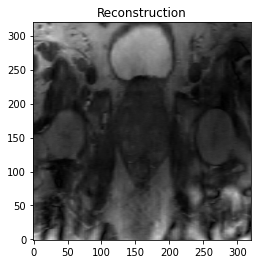

In [159]:
# check out the output file
output_file = Path(SAVE_DIR) / fname.name
with h5py.File(output_file, 'r') as hf_out:
    reconstruction = hf_out['reconstruction'][:]
print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Reconstruction data type: {reconstruction.dtype}")

# plot the cropped version of the first slice of the reconstruction
def center_crop_im(im_2d: np.ndarray, crop_to_size) -> np.ndarray:
    """
    Center crop an image to a given size.
    
    Parameters:
    -----------
    im_2d : numpy.ndarray
        Input image of shape (x, y).
    crop_to_size : list
        List containing the target size for x and y dimensions.
    
    Returns:
    --------
    numpy.ndarray
        Center cropped image of size {x_cropped, y_cropped}. 
    """
    x_crop = im_2d.shape[-1]/2 - crop_to_size[0]/2
    y_crop = im_2d.shape[-2]/2 - crop_to_size[1]/2

    return im_2d[int(y_crop):int(crop_to_size[1] + y_crop), int(x_crop):int(crop_to_size[0] + x_crop)]  

import matplotlib.pyplot as plt
slice_index = 18  # Example slice index to visualize
plt.imshow(center_crop_im(np.abs(reconstruction[slice_index, :, :]), [320, 320]), cmap='gray', origin='lower')
plt.title("Reconstruction")
plt.show()


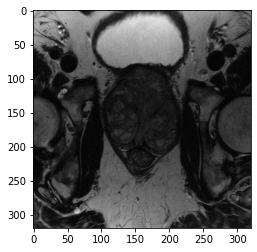

In [160]:
# get reconstruction_rss
with h5py.File(fname, 'r') as hf:
    reconstruction_rss = hf['reconstruction_rss'][:]

# plot
plt.imshow(np.abs(reconstruction_rss[slice_index, :, :]), cmap='gray')


## try out 

In [ ]:
def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func, seed=42) # Use seed for validation data
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

def generate_array(shape, R, mat_file, tensor_out):
    '''
    Generate CS mask for given k_space shape and acceleration factor R
    Args:
        shape (tuple): Shape of the k-space data
        R (int): Acceleration factor
        mat_file: matlab file containing the CS masks
        tensor_out (bool): If True, the output will be a torch tensor
    Returns:
        array (numpy.array or torch.tensor): CS mask 
    '''
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array


def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {} -d 0'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction


### TRY PROCESSING 1 VOLUME
fname = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Prostate/fastMRI_prostate_T2_IDS_041_060/file_prostate_AXT2_041.h5")
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
save_dir = Path("")
acceleration = 4

#def process_volume(fname, save_dir, mat_file, acceleration):
# Timer for the entire file
start_time_file = time.time()   

# Open HDF5 file in read mode
with h5py.File(fname, 'r') as hf:
    kspace = hf['kspace'][:]
    calibration_data = hf['calibration_data'][:]

In [41]:


num_averages, num_slices, num_coils, nx, ny = kspace.shape
cs_recons = np.zeros((num_averages, num_slices, nx, ny), dtype=np.complex64)


# if acceleration == 4:
#     mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
# else:
#     mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])

#### PROSTATE: 3 averages, calculate CS for each before averaging to get result
for avg in range(num_averages):
    avg_kspace = kspace[1] # (num_slices, num_coils, nx, ny)
    
    # Apply mask
    #masked_kspace_ACS, mask_ACS = apply_mask(avg_kspace, mask_func)
    mask = generate_array(avg_kspace.shape, acceleration, mat_file, tensor_out=False)
    masked_kspace = avg_kspace * mask + 0.0

    # compute CS reconstruction
    for slice in range(num_slices):
        S = estimate_sensitivity_maps(calibration_data[slice,:,:,:])
        cs_recons[avg, slice] = CS(masked_kspace[slice,:,:,:], S)

#### average across the 3 averages
cs_data = np.mean(cs_recons, axis=0)  # Average across the first dimension (averages)

# Save the CS data to an HDF5 file
output_file = Path(save_dir) / fname.name
with h5py.File(output_file, 'w') as hf_out:
    hf_out.create_dataset('reconstruction', data=cs_data)


# Timer for the entire file: calculate and print total elapsed time after all slices
end_time_file = time.time()
elapsed_time_file = end_time_file - start_time_file
print(f"Total time for processing the entire file: {elapsed_time_file:.4f} seconds")

Exception: Command exited with an error.

## TRY STEP BY STEP INSTEAD

In [1]:
import argparse
import h5py
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import xml.etree.ElementTree as etree
from fastmri_prostate.reconstruction.t2.prostate_t2_recon import t2_reconstruction
from fastmri_prostate.reconstruction.dwi.prostate_dwi_recon import dwi_reconstruction
from fastmri_prostate.data.mri_data import load_file_T2, load_file_dwi, save_recon
import warnings
import os
warnings.filterwarnings('ignore')


#! Below: Add full folder path to downloaded fastMRI prostate data
fastMRI_dir = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Prostate/"

data_path_t2 = 'fastMRI_prostate_T2_IDS_001_020'
data_path_dwi = 'fastMRI_prostate_DIFF_IDS_001_011'

fname_t2 = os.path.join(fastMRI_dir, data_path_t2, 'file_prostate_AXT2_001.h5')
fname_t2 = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Prostate/fastMRI_prostate_T2_IDS_294_312/file_prostate_AXT2_294.h5")

kspace, calibration_data, ismrmrd_header, reconstruction_rss, image_atts = load_file_T2(fname_t2)


In [4]:
avg_kspace = kspace[2, :, :, :, :]  # Select avg
slice=10
acceleration = 4
mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')



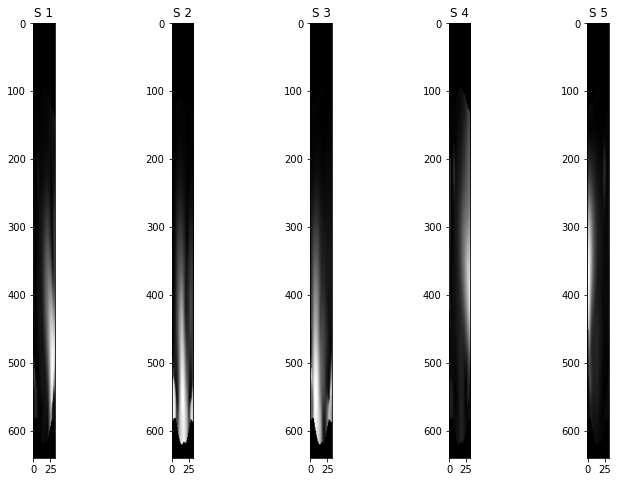

In [35]:

def show_select_sensitivity_maps(S, nc_list):
    fig = plt.figure(figsize=(12,8))
    i = 0
    for nc in nc_list:
        plt.subplot(1, len(nc_list), i+1)
        plt.imshow(abs(S[nc,:,:]), cmap='gray')
        plt.title('S {}'.format(i+1))
        i += 1

S = estimate_sensitivity_maps(calibration_data[slice,:,:,:])
show_select_sensitivity_maps(S, [0, 2, 5, 7, 10])



In [163]:
# fix by first zero padding calibration data
print(f"Calibration data shape: {calibration_data.shape}")
print(f"K-space shape: {kspace.shape}")
# Assuming calibration_data shape is (S, C, RO_calib, PE_calib)
S, C, RO_calib, PE_calib = calibration_data.shape
RO_full, PE_full = kspace.shape[3], kspace.shape[4]  # full k-space spatial dims

calib_padded = np.zeros((S, C, RO_full, PE_full), dtype=calibration_data.dtype)

start_ro = (RO_full - RO_calib) // 2
start_pe = (PE_full - PE_calib) // 2

calib_padded[:, :, start_ro:start_ro + RO_calib, start_pe:start_pe + PE_calib] = calibration_data
print(f"Padded calibration data shape: {calib_padded.shape}")

# Estimate sensitivity maps with ESPIRiT method
S = estimate_sensitivity_maps(calib_padded[slice,:,:,:])
print(f"Sensitivity maps shape: {S.shape}")

Calibration data shape: (30, 30, 640, 32)
K-space shape: (3, 30, 30, 640, 451)
Padded calibration data shape: (30, 30, 640, 451)
Sensitivity maps shape: (30, 640, 451)


In [165]:
mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
S_all = []
masked_calib, mask_ACS = apply_mask(calib_padded, mask_func) # make sure seed is set (unless training)
for slice in range(masked_calib.shape[0]):
    S = estimate_sensitivity_maps(masked_calib[slice,:,:,:]) # (num_coils, RO_calib, PE_calib)
    S_all.append(S)

In [166]:
# check if all elements in S_all are the same
S_all = np.array(S_all)  # Convert list to numpy array for easier comparison
print(f"Number of sensitivity maps: {len(S_all)}")
print(f"Shape of each sensitivity map: {S_all[0].shape}")
# Check if all sensitivity maps are the same
if np.all(S_all == S_all[0]):
    print("All sensitivity maps are the same.")
else:
    print("Sensitivity maps are not the same across slices.")

Number of sensitivity maps: 30
Shape of each sensitivity map: (30, 640, 451)
Sensitivity maps are not the same across slices.


In [ ]:
def show_select_sensitivity_maps(S, nc_list):
    fig = plt.figure(figsize=(12,8))
    i = 0
    for nc in nc_list:
        plt.subplot(1, len(nc_list), i+1)
        plt.imshow(abs(S[nc,:,:]), cmap='gray')
        plt.title('S {}'.format(i+1))
        i += 1
        
show_select_sensitivity_maps(S, [0, 2, 5, 7, 17])

In [ ]:
cs_recons = np.zeros((kspace.shape[0], 1, kspace.shape[3], kspace.shape[4]), dtype=np.complex64)

for avg in range(kspace.shape[0]):
    avg_kspace = kspace[avg] # (num_slices, num_coils, nx, ny)
    
    # Apply mask
    mask = generate_array(avg_kspace.shape, acceleration, mat_file, tensor_out=False)
    masked_kspace = avg_kspace * mask + 0.0

    # compute CS reconstruction
    cs_recons[avg, slice] = CS(masked_kspace[slice,:,:,:], S)

#### average across the 3 averages
cs_data = np.mean(cs_recons, axis=0)  # Average across the first dimension (averages)

In [30]:
# (should've given only 1 to the slice dimension, fix here to select correct slice)
print(f"CS reconstruction shape: {cs_data.shape}")
cs_reconstruction = cs_data[slice,:,:]
print(f"CS reconstruction for slice {slice} shape: {cs_reconstruction.shape}")



CS reconstruction shape: (30, 640, 451)
CS reconstruction for slice 10 shape: (640, 451)


In [31]:
## note: for reconstruction_rss : they flipped when combining coils image_mat[i,:,:] = np.flipud(image), with i each slice
cs_reconstruction = np.flipud(cs_reconstruction)

In [ ]:

# mask = generate_array(avg_kspace.shape, acceleration, mat_file, tensor_out=False)
# masked_kspace = avg_kspace * mask + 0.0
# # Perform CS reconstruction
# cs_reconstruction = CS(masked_kspace[slice,:,:,:], S)


Text(0.5, 1.0, 'CS Reconstruction')

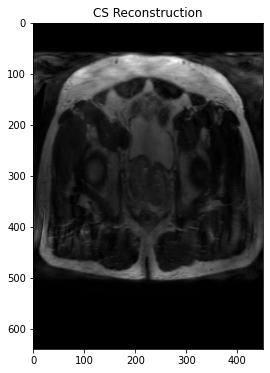

In [32]:
# plot the CS reconstruction
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cs_reconstruction), cmap='gray')
plt.title('CS Reconstruction')


Text(0.5, 1.0, 'CS Reconstruction')

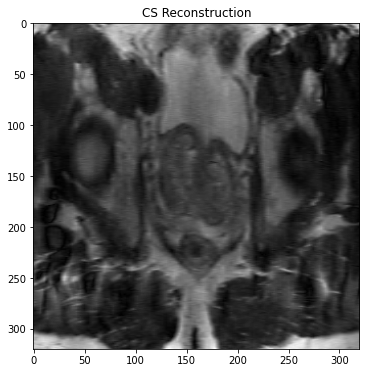

In [33]:
def center_crop_im(im_2d: np.ndarray, crop_to_size) -> np.ndarray:
    """
    Center crop an image to a given size.
    
    Parameters:
    -----------
    im_2d : numpy.ndarray
        Input image of shape (x, y).
    crop_to_size : list
        List containing the target size for x and y dimensions.
    
    Returns:
    --------
    numpy.ndarray
        Center cropped image of size {x_cropped, y_cropped}. 
    """
    x_crop = im_2d.shape[-1]/2 - crop_to_size[0]/2
    y_crop = im_2d.shape[-2]/2 - crop_to_size[1]/2

    return im_2d[int(y_crop):int(crop_to_size[1] + y_crop), int(x_crop):int(crop_to_size[0] + x_crop)]  

cropped_reconstruction = center_crop_im(cs_reconstruction, (320, 320))
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cropped_reconstruction), cmap='gray')
plt.title('CS Reconstruction')



Text(0.5, 1.0, 'RSS Reconstruction')

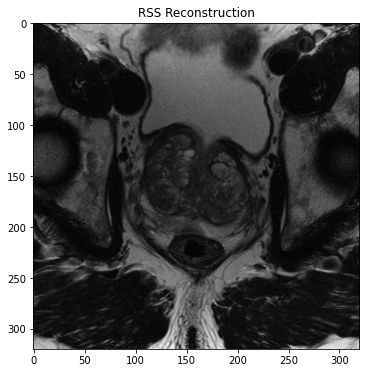

In [34]:
# plot the reconstruction RSS
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(reconstruction_rss[slice,:,:]), cmap='gray')
plt.title('RSS Reconstruction')

# uses center crop: center_crop_im(im_3d, [320, 320])  
# from fastmri_prostate.reconstruction.utils import center_crop_im


Text(0.5, 1.0, 'Mean RSS Reconstruction from 3 Averages')

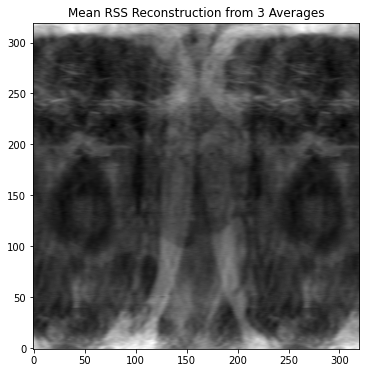

In [39]:
import fastmri
# compute rss image from the mean of the 3 averages
rss_images = np.zeros((kspace.shape[0], kspace.shape[3], kspace.shape[4]), dtype=np.complex64)
for avg in range(kspace.shape[0]):
    avg_kspace = kspace[avg] # (num_slices, num_coils, nx, ny)
    masked_kspace = avg_kspace * mask + 0.0
    rss_image = fastmri.ifft2c(T.to_tensor(masked_kspace[slice,:,:,:]))
    rss_image = fastmri.complex_abs(rss_image)
    rss_image = fastmri.rss(rss_image, dim=0)
    rss_images[avg] = np.flipud(rss_image)
    # rss_images[avg] = rss_image.numpy()  # Convert tensor to numpy array
# compute mean rss image
mean_rss_image = np.mean(rss_images, axis=0)
# show mean rss image
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(center_crop_im(mean_rss_image, [320, 320])), cmap='gray', origin='lower')
plt.title('Mean RSS Reconstruction from 3 Averages')

NOTE: R=4 already looks very tuff to reconstruct (is actually R=6 or so, because of the avgs, see article)
R=8 probably impossible


look if for R=4: 
- maybe better if you do all averages + compute mean?
- maybe better for one of the avg (1 looks best, definitely try avg'ing them!)

## look at kspace

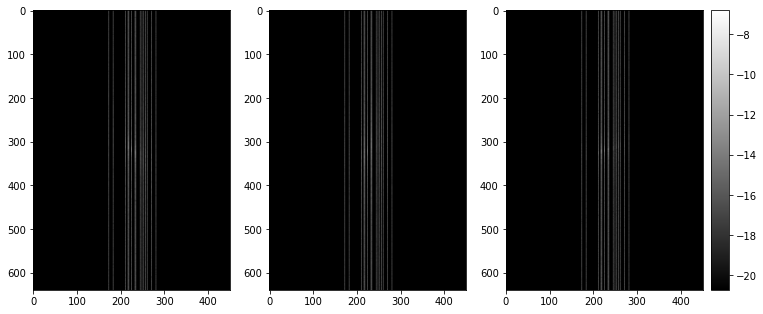

In [82]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(12,8))
    for i, num in enumerate(slice_nums):
        ax = plt.subplot(1, len(slice_nums), i + 1)
        im = ax.imshow(data[num], cmap=cmap)
        # Create an axes for the colorbar. The position of the axes is calculated based on the position of ax.
        # Adjust the distance between the main image and the colorbar (0.01) and the width of the colorbar (0.02) as needed.
    cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax) # Add the colorbar to the figure
    plt.show()

show_coils(np.log(np.abs(masked_kspace[slice]) + 1e-9), [0, 5, 10], cmap='gray')

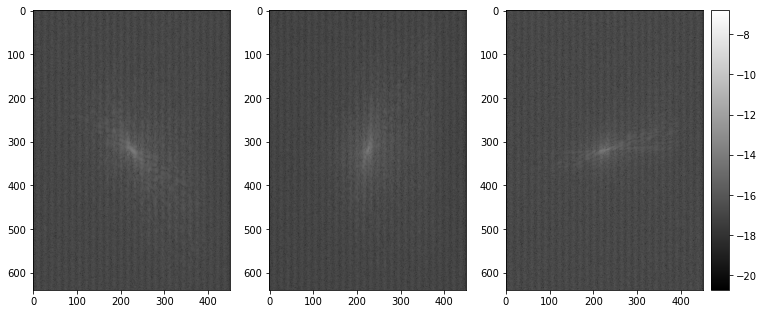

In [83]:
show_coils(np.log(np.abs(avg_kspace[slice]) + 1e-9), [0, 5, 10], cmap='gray')

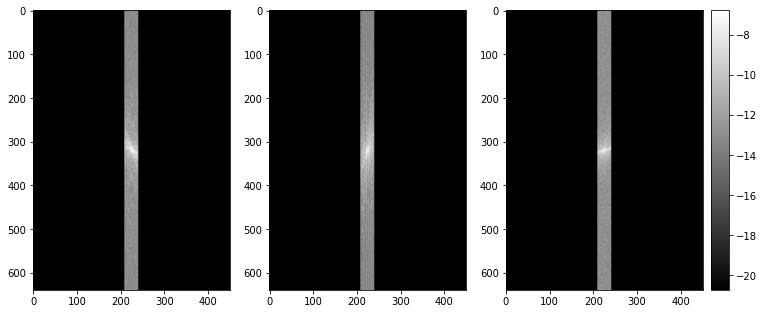

Calibration data shape: (30, 30, 640, 451)
Number of non-zero columns in calibration data for slice 10: 32


In [94]:
show_coils(np.log(np.abs(calib_padded[slice]) + 1e-9), [0, 5, 10], cmap='gray')
# count non-zero columns in the calibration data
print(f"Calibration data shape: {calib_padded.shape}")
calib_padded_coil = calib_padded[slice, 1,:,:]  # Select coil 1 for the slice
# Count amount of non-zero columns in the calibration data for the selected slice and coil
non_zero_columns = np.count_nonzero(calib_padded_coil[1,:]) # select one row
print(f"Number of non-zero columns in calibration data for slice {slice}: {non_zero_columns}")


### try to create mask that halves amount of lines myself

Calib padded shape: (30, 30, 640, 32)
Calib padded shape after cropping: (30, 30, 640, 16)
Calib padded shape after zero padding: (30, 30, 640, 451)


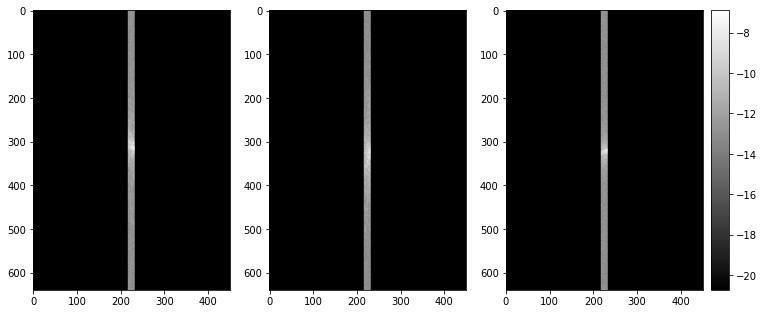

Number of non-zero columns in calibration data for slice 10 after cropping: 16


In [98]:
print(f"Calib padded shape: {calibration_data.shape}")
# center crop the calibration data to half the phase encoding size (4th dimension)
calibration_data_cropped = calibration_data[:,:,:,:calibration_data.shape[3]//2]
print(f"Calib padded shape after cropping: {calibration_data_cropped.shape}")
# Assuming calibration_data shape is (S, C, RO_calib, PE_calib)
S, C, RO_calib, PE_calib = calibration_data_cropped.shape
RO_full, PE_full = kspace.shape[3], kspace.shape[4]  # full k-space spatial dims

calib_padded_halfed = np.zeros((S, C, RO_full, PE_full), dtype=calibration_data.dtype)

start_ro = (RO_full - RO_calib) // 2
start_pe = (PE_full - PE_calib) // 2

calib_padded_halfed[:, :, start_ro:start_ro + RO_calib, start_pe:start_pe + PE_calib] = calibration_data_cropped


print(f"Calib padded shape after zero padding: {calib_padded_halfed.shape}")

show_coils(np.log(np.abs(calib_padded_halfed[slice]) + 1e-9), [0, 5, 10], cmap='gray')
# count non-zero columns in the calibration data
calib_padded_halfed_coil = calib_padded_halfed[slice, 1,:,:]  # Select coil 1 for the slice
# Count amount of non-zero columns in the calibration data for the selected slice and coil
non_zero_columns_halfed = np.count_nonzero(calib_padded_halfed_coil[1,:]) # select one row
print(f"Number of non-zero columns in calibration data for slice {slice} after cropping: {non_zero_columns_halfed}")

### Instead, just use equispacedmask on padded calibration data??


Masked calibration data shape: (30, 30, 640, 451)


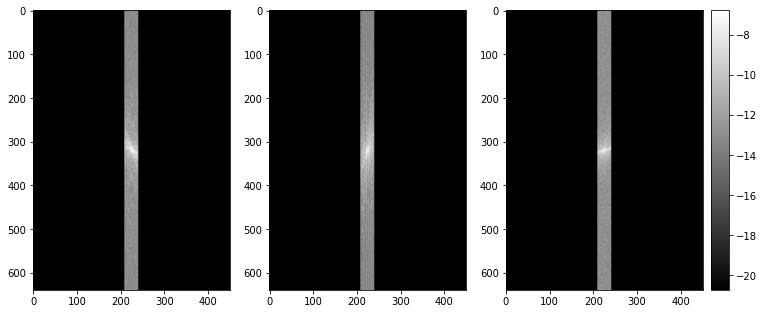

Number of non-zero columns in masked calibration data for slice 10: 32


In [99]:
mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_calib_ACS, mask_ACS = apply_mask(calib_padded, mask_func)

print(f"Masked calibration data shape: {masked_calib_ACS.shape}")
show_coils(np.log(np.abs(masked_calib_ACS[slice]) + 1e-9), [0, 5, 10], cmap='gray')
# count non-zero columns in the calibration data
non_zero_columns = np.count_nonzero(masked_calib_ACS[slice, 1, 1,:]) # select one row of 1 coil
print(f"Number of non-zero columns in masked calibration data for slice {slice}: {non_zero_columns}")

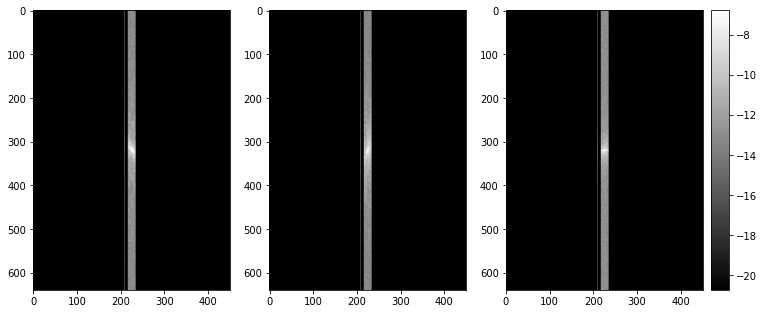

Number of non-zero columns in masked calibration data for slice 10: 19


In [97]:
mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])
masked_calib_ACS, mask_ACS = apply_mask(calib_padded, mask_func)

show_coils(np.log(np.abs(masked_calib_ACS[slice]) + 1e-9), [0, 5, 10], cmap='gray')
# count non-zero columns in the calibration data
non_zero_columns = np.count_nonzero(masked_calib_ACS[slice, 1, 1,:]) # select one row of 1 coil
print(f"Number of non-zero columns in masked calibration data for slice {slice}: {non_zero_columns}")

## Tests to debug what is wrong with BART

In [ ]:
mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace_ACS, mask_ACS = apply_mask(avg_kspace, mask_func)

slice_kspace = masked_kspace_ACS[slice,:,:,:]  # Select first slice

#### Estimate sensitivity maps with ESPIRiT method
# Move coil axis to the back as expected by BART
kspace_perm = np.moveaxis(slice_kspace, 0, 2)
# Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
kspace_perm = np.expand_dims(kspace_perm, axis=2)
writecfl("slice_input", kspace_perm)
# Estimate sensitivity maps with ESPIRiT method
# S = bart.bart(1, "ecalib -m1", kspace_perm)
# # Undo the previous operations to get the original data structure back
# S = np.moveaxis(S.squeeze(), 2, 0)

## NOW IN TERMINAL: bart ecalib -m1 slice_input sens_out

In [ ]:
avg_kspace = kspace[1] # (num_slices, num_coils, nx, ny)

# Apply mask
#masked_kspace_ACS, mask_ACS = apply_mask(avg_kspace, mask_func)
mask = generate_array(avg_kspace.shape, acceleration, mat_file, tensor_out=False)
masked_kspace = avg_kspace * mask + 0.0


# Move coil axis to the back as expected by BART
kspace_perm = np.moveaxis(masked_kspace, 0, 2)
S_perm = np.moveaxis(S, 0, 2)
# Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
kspace_perm = np.expand_dims(kspace_perm, axis=2)
print(f"kspace_perm shape: {kspace_perm.shape}")
S_perm = np.expand_dims(S_perm, axis=2)
print(f"S_perm shape: {S_perm.shape}")

writecfl("slice_kspace", kspace_perm)
writecfl("slice_sens", S_perm)

## NOW IN TERMINAL: bart pics -S -l1 -r 0.005 -i 50 slice_kspace slice_sens cs_recon

kspace_perm shape: (20, 640, 1, 30, 451)
S_perm shape: (640, 32, 1, 20)
